## 데이터 준비 단계 - selenium

In [ ]:
# 데이터 준비
# 데이터 시각화 -> 워드클라우드, 한강별 방문객 시각화 folium
# 감성분석을 위한 kss
# 모델링으로 종료





# 지도 시각화 
# 위치 데이터 크롤링
# 시설, 맛집 등

In [31]:
import requests
from bs4 import BeautifulSoup
import selenium
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By

import pandas as pd
import glob
import time
import numpy as np

import warnings
#브라우저 꺼짐 방지
chrome_options = Options()
chrome_options.add_experimental_option('detach',True)
#불필요한 에러 메세지 없애기
chrome_options.add_experimental_option('excludeSwitches',['enable-logging'])

warnings.filterwarnings('ignore',category=DeprecationWarning)

In [ ]:
service = Service(executable_path = ChromeDriverManager().install()) #드라이버 열기
driver = webdriver.Chrome(service=service,options=chrome_options)
driver.get('https://www.google.co.kr/maps/')

In [ ]:
# 검색
# 광나루, 잠실, 뚝섬, 잠원, 반포, 이촌, 여의도, 양화, 난지, 망원, 강서 한강공원에 대해 각각 진행
search_key = input('검색어를 입력하세요 : ') 
input_tag = driver.find_element(By.XPATH, '//*[@id="searchboxinput"]')
input_tag.send_keys(search_key)
driver.find_element(By.XPATH, '//*[@id="searchbox-searchbutton"]').click()
#input_tag.send_keys("\n") # enter key 입력
driver.implicitly_wait(3) 

#리뷰칸 클릭
driver.find_element(By.XPATH, '//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[3]/div/div/button[2]/div[2]/div[2]').click()

In [ ]:
# <자세히> 열어서 전체 리뷰칸 열어주기
while True:
    driver.find_element(By.CSS_SELECTOR, 'span:nth-child(2) > button').click()
    time.sleep(1)
#더 열 수 있는 리뷰가 없을 경우 오류가 나며 멈추게 된다.

In [ ]:
html = driver.page_source
soup = BeautifulSoup(html,'html.parser')
content = soup.select('.MyEned')

txt = []
for i in range(len(content)):
    txt.append(content[i].text)

df = pd.DataFrame(txt)
df.to_csv('../data/%s.csv'%search_key,encoding='UTF-8',sep=',') #검색어 명으로 csv파일 저장

## 모두 불러온 리뷰를 이용해 워드클라우드 진행
### - 전체 한강 리뷰에 대해 단어 빈도수 확인 및 시각화

In [6]:
df = pd.DataFrame()
rv = glob.glob('../data/한강리뷰_csv/*')
lis = []
for file in rv:
    data = pd.read_csv(file)
    del data['Unnamed: 0']
    data.columns = ['리뷰']
    df = pd.concat([df,data])

In [11]:
df = df.reset_index()
del df['index']

In [16]:
df.to_csv('../data/한강리뷰_csv/all.txt', index = False)

In [20]:
al = open('../data/한강리뷰_csv/all.txt', encoding = 'UTF-8').read()

In [23]:
from konlpy.tag import Okt
import nltk
t = Okt()
all_n = t.nouns(al)
df1 = pd.DataFrame({'명사': all_n})
ko = nltk.Text(all_n)
freq = ko.vocab()
freq_all = pd.DataFrame.from_dict(data=freq, orient='index')
freq_all.columns = ['빈도수']

#전체 한강공원 빈도수 확인 
all_noun=freq_all.sort_values(by= '빈도수', ascending=False)
ko = all_noun.head(50)
# 상위 50개 출력

#### 워드 클라우드

In [28]:
import matplotlib.pyplot as plt
import platform
from wordcloud  import WordCloud
import PIL

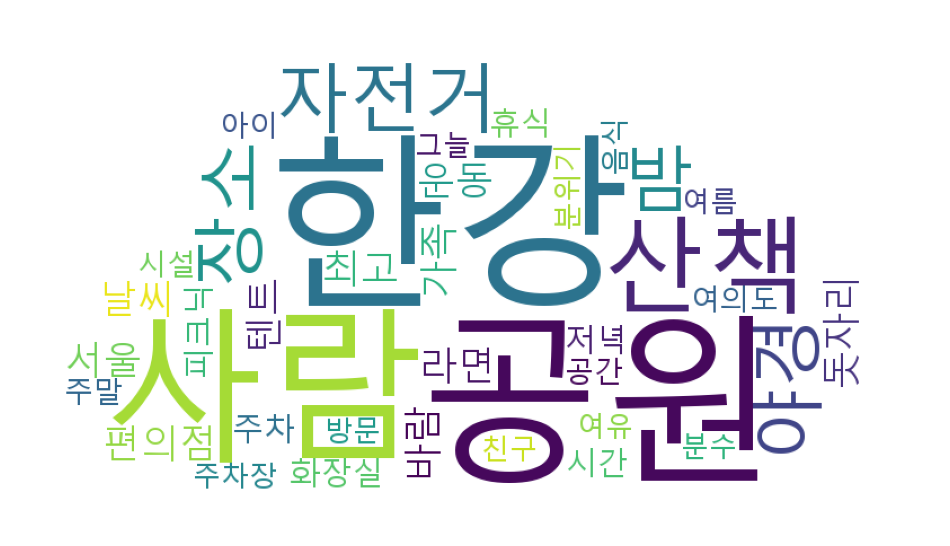

In [33]:
okt = Okt()
stop_words = ['곳','수','것','때','등','타고','매우','좀','아주','더','날','정말']
df1 = ko.drop(stop_words)
df2 = df1.reset_index()
word_dict = df2.set_index('index').to_dict()['빈도수']
icon = PIL.Image.open('../data/cloud.png')
img = PIL.Image.new('RGB', icon.size, (255, 255, 255))
img.paste(icon, icon)
img = np.array(img)

wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                      relative_scaling= 0.1,
                      width = 400, height = 400,
                      background_color='white', mask = img).generate_from_frequencies(word_dict)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# 단어 빈도수 파악으로 속성기반 감성분석(ABSA)에서 속성 분류 진행

## 다음으로 감성분석 진행 

In [41]:
# 감성분석 진행에 있어서 Okt 패키지의 pos()로 형태소를 나눌 경우
# 너무 자세한 분류가 진행되어 속성 부여 문제 발생

# 이를 해결하고자 라벨링 진행 계획
# 라벨링을 위해 각 공원의 리뷰를 index, rep으로 나누고 한 리뷰에 대해 몇번째 문장인지 rep로 표시
# 문장 나누는 것은 kss로 진행
from kss import split_sentences

In [52]:
rv = glob.glob('../data/한강리뷰_csv/*.csv')

In [53]:
rv

['../data/한강리뷰_csv\\banpo.csv',
 '../data/한강리뷰_csv\\dduk.csv',
 '../data/한강리뷰_csv\\gangseo.csv',
 '../data/한강리뷰_csv\\gm_ichon.csv',
 '../data/한강리뷰_csv\\gm_jamsil.csv',
 '../data/한강리뷰_csv\\gwang.csv',
 '../data/한강리뷰_csv\\jamwon.csv',
 '../data/한강리뷰_csv\\mang.csv',
 '../data/한강리뷰_csv\\nanji.csv',
 '../data/한강리뷰_csv\\yanghwa.csv',
 '../data/한강리뷰_csv\\yeouido.csv']

In [50]:
lis = []
for file in rv:
    data = pd.read_csv(file)
    lis.append(data)

In [55]:
names = ['banpo','ddukssum','gangseo','yeechon','jamsil','gwangnaroo','jamwon','mangwon','nanji','yanghwa','yydo']

for i in range(len(lis)):
    lis[i].columns = ['index','리뷰']
    new_df = pd.DataFrame()
    for j in range(len(lis[i])):
        a = split_sentences(lis[i]['리뷰'][j]) #kss 패키지 이용(split_sentences)하여 문장 
        b = len(a)
        c = list(map(lambda x: x, range(b)))
        nd = pd.DataFrame(data = [a,c])
        nd = nd.transpose()
        nd['index'] = j
        new_df = pd.concat([new_df,nd])
    new_df.columns = ['리뷰','rep','index'] #split 문장에 rep, 기존 index(문장출처) 부여
    new_df.reset_index().drop('level_0',axis=1,inplace=True)
    new_df.to_csv('../data/리뷰_rep/%s.csv'%names[i])
    
# 개별 갯수
# 0 / 반포 : 4475
# 1 / 뚝섬 : 333
# 2 / 강서 : 137
# 3 / 이촌 : 603
# 4 / 잠실 : 2493
# 5 / 광나루 : 489
# 6 / 잠원 : 1295
# 7 / 망원 : 3113
# 8 / 난지 : 799
# 9 / 양화 : 812
# 10 / 여의도 : 3992

### 속성 부여하기 위해 split한 문장에 대해 라벨링 진행